In [19]:
import scipy.io as spio
import numpy as np
from utilities import *
from sklearn.model_selection import train_test_split

In [2]:
# Input data
x_mat = spio.loadmat(file_name='../data/bci_EEG_data-dl_proj-final/final_imagery.mat')
print(x_mat.keys())
x_data = x_mat['data']
print(x_data.shape, x_data.dtype)

dict_keys(['__header__', '__version__', '__globals__', 'data'])
(920, 3584, 13) float64


In [3]:
# Output data: class labels
y_mat = spio.loadmat(file_name='../data/bci_EEG_data-dl_proj-final/new_imagery_label.mat')
print(y_mat.keys())
y_labels = y_mat['new_imagery_label']
print(y_labels.shape, y_labels.dtype)
print(np.mean(y_labels==0), np.mean(y_labels==1), np.mean(y_labels==2), np.mean(y_labels==3))

dict_keys(['__header__', '__version__', '__globals__', 'new_imagery_label'])
(920, 1) uint16
0.0 0.5 0.5 0.0


In [4]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_data,
                                                      y_labels,
                                                      stratify = y_labels,
                                                      random_state = 123,
                                                      test_size=0.30)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)
print(X_train.dtype, X_valid.dtype, Y_train.dtype, Y_valid.dtype)

(644, 3584, 13) (276, 3584, 13) (644, 1) (276, 1)
float64 float64 uint16 uint16


In [5]:
# Standardize/normalize train and test
X_train_norm, X_valid_norm = standardize(train=X_train, test=X_valid)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype)

(644, 3584, 13) float64 (276, 3584, 13) float64


In [6]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(y_labels[0].max(axis=0)+1)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 10 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 6 3584 13
n_classes 2


In [7]:
Y_train_onehot = one_hot(labels=Y_train.reshape(-1), n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid.reshape(-1), n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape)

(644, 2) (276, 2) (644, 3584, 13) (276, 3584, 13)


In [8]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [9]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [10]:
# with graph.as_default():
# (451, 3072, 13) float64 (193, 3072, 13) float64 (276, 3072, 13) float64
# (4536, 192, 64) (1944, 192, 64) (4536,) (1944,)
# (644, 3584, 13) (276, 3584, 13) (644, 1) (276, 1)
# (batch, 3584, 64) --> (batch, 1792, 128)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=128, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(conv1.shape, max_pool_1.shape)

# (batch, 1792, 128) --> (batch, 896, 256)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=256, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(conv2.shape, max_pool_2.shape)

# (batch, 896, 256) --> (batch, 448, 512)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=512, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(conv3.shape, max_pool_3.shape)

# (batch, 448, 512) --> (batch, 224, 1024)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=1024, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(conv4.shape, max_pool_4.shape)

(?, 3584, 128) (?, 1792, 128)
(?, 1792, 256) (?, 896, 256)
(?, 896, 512) (?, 448, 512)
(?, 448, 1024) (?, 224, 1024)


In [11]:
# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 224*1024))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print(max_pool_4.shape, flat.shape, logits.shape)

(?, 224, 1024) (?, 229376) (?, 2)


In [12]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            val_acc_ = []
            val_loss_ = []    
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
                
                # Feed
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  

                # Loss
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                val_acc_.append(acc_v)
                val_loss_.append(loss_v)

            # Store
            validation_acc.append(np.mean(val_acc_))
            validation_loss.append(np.mean(val_loss_))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(validation_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(validation_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/10 Train loss: 0.770580 Valid loss: 0.776016 Train acc: 0.518692 Valid acc: 0.505215
Epoch: 2/10 Train loss: 0.719654 Valid loss: 0.750967 Train acc: 0.570093 Valid acc: 0.507229
Epoch: 3/10 Train loss: 0.676460 Valid loss: 0.741732 Train acc: 0.629803 Valid acc: 0.509605
Epoch: 4/10 Train loss: 0.618943 Valid loss: 0.745470 Train acc: 0.675623 Valid acc: 0.512216
Epoch: 5/10 Train loss: 0.548733 Valid loss: 0.763013 Train acc: 0.725857 Valid acc: 0.517222
Epoch: 6/10 Train loss: 0.487468 Valid loss: 0.813731 Train acc: 0.762461 Valid acc: 0.519978
Epoch: 7/10 Train loss: 0.443215 Valid loss: 0.854747 Train acc: 0.787494 Valid acc: 0.522736
Epoch: 8/10 Train loss: 0.402165 Valid loss: 0.893585 Train acc: 0.810358 Valid acc: 0.525282
Epoch: 9/10 Train loss: 0.370982 Valid loss: 0.942892 Train acc: 0.826410 Valid acc: 0.527590
Epoch: 10/10 Train loss: 0.347115 Valid loss: 0.985295 Train acc: 0.839564 Valid acc: 0.529656


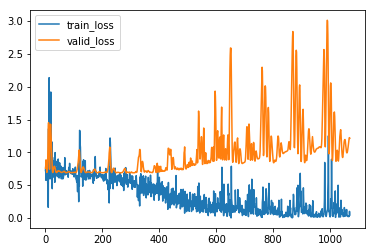

In [16]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(validation_loss, label='valid_loss')
mplot.legend()
mplot.show()

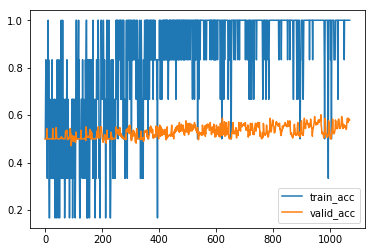

In [18]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(validation_acc, label='valid_acc')
mplot.legend()
mplot.show()